In [30]:
import pandas as pd

# Load the dataset
data = pd.read_csv(r"C:\Users\USER\Chameleon\MOP-Code\artificial-intelligence\Traffic Analysis\dataset\traffic_volume_analysis_new.csv")



# Display the first few rows and summary of the dataset
data_info = data.info()
data_head = data.head()

data_info, data_head


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63120 entries, 0 to 63119
Data columns (total 51 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   road_name                        63120 non-null  object 
 1   location                         63120 non-null  object 
 2   suburb                           63120 non-null  object 
 3   speed_limit                      63120 non-null  int64  
 4   direction                        63120 non-null  object 
 5   Light_Vehicles                   63120 non-null  float64
 6   Light_Vehicles_with_Trailer      63120 non-null  float64
 7   Two_Axle_Trucks_Buses            63120 non-null  float64
 8   Three_Axle_Trucks_Buses          63120 non-null  float64
 9   Four_Axle_Trucks                 63120 non-null  float64
 10  Three_Axle_Articulated_Vehicles  63120 non-null  float64
 11  Four_Axle_Articulated_Vehicles   63120 non-null  float64
 12  Five_Axle_Articula

(None,
          road_name                    location      suburb  speed_limit  \
 0  Wolseley Parade  North East Of Derby Street  Kensington           50   
 1  Wolseley Parade  North East Of Derby Street  Kensington           50   
 2  Wolseley Parade  North East Of Derby Street  Kensington           50   
 3  Wolseley Parade  North East Of Derby Street  Kensington           50   
 4  Wolseley Parade  North East Of Derby Street  Kensington           50   
 
   direction  Light_Vehicles  Light_Vehicles_with_Trailer  \
 0         W       24.000000                     0.386506   
 1         W       42.000000                     0.386506   
 2         W       33.000000                     0.386506   
 3         W        3.000000                     0.386506   
 4         W       86.177384                     0.386506   
 
    Two_Axle_Trucks_Buses  Three_Axle_Trucks_Buses  Four_Axle_Trucks  ...  \
 0               4.093996                 0.608382          0.260623  ...   
 1           

In [32]:
data['road_name'] = data['road_name'].replace({
    'Abbotsford Street': 'Abbottsford Street'
})
# Aggregating the data by road_name
aggregated_data = data.groupby('road_name').agg({
    'speed_limit': 'mean',
    'average_speed': 'mean',
    '85th_percentile_speed': 'mean',
    'maximum_speed': 'max',
    'Total_Traffic_Volume': 'sum',
    'Speeding_Incident': 'sum'  # Summing up the incidents
}).reset_index()

# Define a new target variable: 1 if the road segment has a high number of speeding incidents and high traffic volume
traffic_threshold_agg = aggregated_data['Total_Traffic_Volume'].quantile(0.75)
speeding_threshold_agg = aggregated_data['Speeding_Incident'].quantile(0.75)

aggregated_data['High_Risk_Segment'] = (
    (aggregated_data['Total_Traffic_Volume'] > traffic_threshold_agg) & 
    (aggregated_data['Speeding_Incident'] > speeding_threshold_agg)
).astype(int)

# Display the aggregated data
aggregated_data




,road_name,speed_limit,average_speed,85th_percentile_speed,maximum_speed,Total_Traffic_Volume,Speeding_Incident,High_Risk_Segment
0,Abbottsford Street,50.0,36.497214,43.005138,107.000000,100672.066744,876,1
1,Adderley Street,50.0,39.232528,44.796827,91.000000,64745.015644,625,0
2,Agnes Street,50.0,22.152814,26.417281,46.918791,5083.445532,0,0
3,Anderson Street,45.0,39.279653,45.898441,156.000000,164033.200573,1108,1
4,Anthony Street,50.0,25.337070,30.392575,74.000000,9492.606485,43,0
...,...,...,...,...,...,...,...,...
102,Walsh Street,50.0,30.291228,35.972338,58.000000,12559.143879,27,0
103,Wells Place,20.0,22.532718,25.838167,46.918791,50642.000806,642,0
104,Wells Street,50.0,22.522611,25.734525,145.000000,15149.419853,2,0
105,William Street,50.0,25.303786,30.298831,114.000000,205653.305538,204,0


In [34]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Prepare the features and target
features_lgb = aggregated_data[['speed_limit', 'average_speed', '85th_percentile_speed',
                                'maximum_speed', 'Total_Traffic_Volume', 'Speeding_Incident']]
target_lgb = aggregated_data['High_Risk_Segment']

# Split the data into training and test sets
X_train_lgb, X_test_lgb, y_train_lgb, y_test_lgb = train_test_split(
    features_lgb, target_lgb, test_size=0.3, random_state=42, stratify=target_lgb)

# Create and train the LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train_lgb, y_train_lgb)

# Make predictions on the test set
y_pred_lgb = lgb_model.predict(X_test_lgb)

# Evaluate the model
accuracy_lgb = accuracy_score(y_test_lgb, y_pred_lgb)
classification_report_lgb = classification_report(y_test_lgb, y_pred_lgb)

print("Accuracy:", accuracy_lgb)
print("Classification Report:\n", classification_report_lgb)

[LightGBM] [Info] Number of positive: 12, number of negative: 62
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 126
[LightGBM] [Info] Number of data points in the train set: 74, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.162162 -> initscore=-1.642228
[LightGBM] [Info] Start training from score -1.642228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

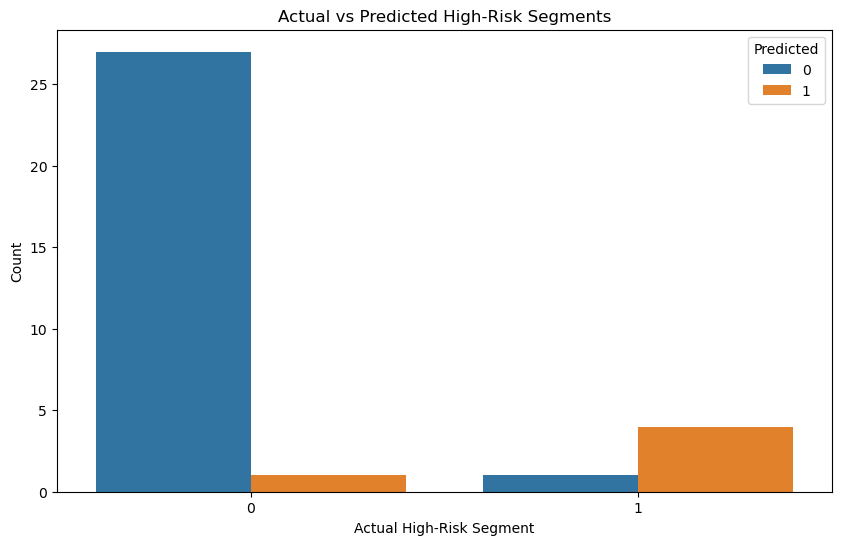

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a DataFrame with predictions, actual values, and additional features for plotting
results_df = pd.DataFrame({
    'Actual_High_Risk_Segment': y_test_lgb,
    'Predicted_High_Risk_Segment': y_pred_lgb
})

# Plot the results
plt.figure(figsize=(10, 6))

# Plot the count of actual vs predicted values
sns.countplot(x='Actual_High_Risk_Segment', hue='Predicted_High_Risk_Segment', data=results_df)

plt.title('Actual vs Predicted High-Risk Segments')
plt.xlabel('Actual High-Risk Segment')
plt.ylabel('Count')
plt.legend(title='Predicted', loc='upper right')
plt.show()



In [42]:
# Define a threshold for "significant speeding" (e.g., 10 km/h over the speed limit)
speeding_threshold = 10

# Calculate speeding violation (boolean)
data['Speeding_Violation'] = data['average_speed'] > (data['speed_limit'] + speeding_threshold)

# Group by road name to aggregate speeding violations and traffic volume
speeding_analysis = data.groupby('road_name').agg({
    'Speeding_Violation': 'mean',  # Percentage of vehicles speeding
    'Total_Traffic_Volume': 'sum',  # Total traffic volume
    'average_speed': 'mean',  # Average speed
    'Latitude': 'mean',  # Latitude for mapping
    'Longitude': 'mean'  # Longitude for mapping
}).reset_index()

# Flag high-risk segments where the speeding rate is above a certain threshold (e.g., 20%)
speeding_threshold_rate = 0.2
speeding_analysis['High_Risk_Speeding'] = speeding_analysis['Speeding_Violation'] > speeding_threshold_rate

# Flag high-risk segments where both traffic volume and average speed are high
volume_threshold = speeding_analysis['Total_Traffic_Volume'].quantile(0.75)
speed_threshold = speeding_analysis['average_speed'].quantile(0.75)

speeding_analysis['High_Risk_Volume_Speed'] = (
    (speeding_analysis['Total_Traffic_Volume'] > volume_threshold) & 
    (speeding_analysis['average_speed'] > speed_threshold)
)

# Combine both analyses to flag segments as high-risk if they meet either criterion
speeding_analysis['Overall_High_Risk'] = speeding_analysis['High_Risk_Speeding'] | speeding_analysis['High_Risk_Volume_Speed']

# Display the high-risk segments
high_risk_segments = speeding_analysis[speeding_analysis['Overall_High_Risk']]
high_risk_segments.head()


,road_name,Speeding_Violation,Total_Traffic_Volume,average_speed,Latitude,Longitude,High_Risk_Speeding,High_Risk_Volume_Speed,Overall_High_Risk
0,Abbottsford Street,0.000000,100672.066744,36.497214,-37.805360,144.944879,False,True,True
3,Anderson Street,0.042411,164033.200573,39.279653,-37.824451,144.973744,False,True,True
5,Arden Street,0.000000,266017.153068,43.389881,-37.800074,144.941738,False,True,True
28,Epsom Road,0.000000,111307.879094,38.389881,-37.793198,144.926813,False,True,True
31,Flemington Road,0.000000,199715.704956,40.642857,-37.800117,144.955597,False,True,True


In [44]:
# Group by road name to aggregate speeding violations and traffic volume
speeding_analysis = data.groupby('road_name').agg({
    'Speeding_Violation': 'mean',  # Percentage of vehicles speeding
    'Total_Traffic_Volume': 'sum',  # Total traffic volume
    'average_speed': 'mean',  # Average speed
    'Latitude': 'mean',  # Latitude for mapping
    'Longitude': 'mean'  # Longitude for mapping
}).reset_index()

# Flag high-risk segments where the speeding rate is above a certain threshold (e.g., 20%)
speeding_threshold_rate = 0.2
speeding_analysis['High_Risk_Speeding'] = speeding_analysis['Speeding_Violation'] > speeding_threshold_rate

# Flag high-risk segments where both traffic volume and average speed are high
volume_threshold = speeding_analysis['Total_Traffic_Volume'].quantile(0.75)
speed_threshold = speeding_analysis['average_speed'].quantile(0.75)

speeding_analysis['High_Risk_Volume_Speed'] = (
    (speeding_analysis['Total_Traffic_Volume'] > volume_threshold) & 
    (speeding_analysis['average_speed'] > speed_threshold)
)

# Combine both analyses to flag segments as high-risk if they meet either criterion
speeding_analysis['Overall_High_Risk'] = speeding_analysis['High_Risk_Speeding'] | speeding_analysis['High_Risk_Volume_Speed']

# Display the high-risk segments
high_risk_segments = speeding_analysis[speeding_analysis['Overall_High_Risk']]
high_risk_segments.head()


,road_name,Speeding_Violation,Total_Traffic_Volume,average_speed,Latitude,Longitude,High_Risk_Speeding,High_Risk_Volume_Speed,Overall_High_Risk
0,Abbottsford Street,0.000000,100672.066744,36.497214,-37.805360,144.944879,False,True,True
3,Anderson Street,0.042411,164033.200573,39.279653,-37.824451,144.973744,False,True,True
5,Arden Street,0.000000,266017.153068,43.389881,-37.800074,144.941738,False,True,True
28,Epsom Road,0.000000,111307.879094,38.389881,-37.793198,144.926813,False,True,True
31,Flemington Road,0.000000,199715.704956,40.642857,-37.800117,144.955597,False,True,True


In [46]:
import folium

# Initialize a map centered around the average coordinates of the high-risk segments
center_lat = high_risk_segments['Latitude'].mean()
center_lon = high_risk_segments['Longitude'].mean()
high_risk_map = folium.Map(location=[center_lat, center_lon], zoom_start=13)

# Plot each high-risk segment
for idx, row in high_risk_segments.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"Road: {row['road_name']}<br>Speeding Violation Rate: {row['Speeding_Violation']*100:.2f}%<br>Total Traffic Volume: {row['Total_Traffic_Volume']}",
        icon=folium.Icon(color='red' if row['Overall_High_Risk'] else 'blue')
    ).add_to(high_risk_map)

# Save the map as an HTML file
map_file_path = r"C:\Users\USER\Downloads/high_risk_road_segments_map.html"
high_risk_map.save(map_file_path)

map_file_path


'C:\\Users\\USER\\Downloads/high_risk_road_segments_map.html'